# SI 671/721 (Fall 2020) Data Mining: Methods and Applications
**Instructor:** Paramveer Dhillon

**GSIs**: Lingyun Guo, Kwame Porter Robinson

**Homework 1:** How Far Would You Go for Italian Mozzarella? Exploring the impact of product cost and purchase frequency on distance traveled by Italian consumers

**Due:** 10.5.2020

**Total Points:** 100

# 1 Summary

We will use the supermarket dataset described in Pennacchioli et al. (2013) for this homework [1]. The dataset was obtained from one of the largest Italian retail distribution companies, _Coop_. It includes three space delimited files:
  * `supermarket_distances` A matrix of distances for customers and visited stores.
  * `supermarket_prices` A matrix of prices and products.
  * `supermarket_purchases` A transaction matrix of customers, products, visited stores, as well as the quantity of purchased products.

We will use concepts from data mining to explore interesting associations within the dataset. This exploration will support our investigation into the effects of product cost, purchase frequency on the distance traveled by Italian consumers.

We recommend that you use Jupyter notebooks and Python libraries `Pandas` and `Scipy` for this homework. We also recommend that you use`Numpy`, `Matplotlib`, `Seaborn`, and `apyori`. However, feel free to use whatever language and library that you would like.

**Your Jupyter notebook should contain for each answer a few line description of your solution or approach along with any code. Do not only submit code.**

References:

[1] Pennacchioli et al. "Explaining the product range effect in purchase data" (2013) BigData. DOI: [doi.org/10.1109/BigData.2013.6691634](https://doi.org/10.1109/BigData.2013.6691634)

# 2 Details

This homework is divided into two parts.

Part 1. Data Exploration

Part 2. Exploring product frequency, price and distance traveled

### Name: Yashaswini Joshi     
### Unique Name: yjoshi

# 2.1 Part 1: Data Exploration [50 Points]
This part of the homework is designed to help you familiarize yourself with the datasets and basic concepts of itemset mining. The insights from this part of the homework will help you in Part 2 of the homework.

### 2.1.1: Better understand the _Coop_ supermarket dataset

 a) [5 points] To gain more insight into the dataset and problem motivation, please read the following: 
 *  The `Introduction` section of [Pennacchioli et al. "Explaining the product range effect in purchase data" (2013) BigData.](http://www.michelecoscia.com/wp-content/uploads/2013/09/geocoop.pdf)
 * A deeper explanation  of the [*Supermarket Data* here](http://www.michelecoscia.com/?page_id=379)
 

b) [5 points] Download [the supermarket dataset here](http://michelecoscia.com/wp-content/uploads/2013/02/supermarket_data.zip). The dataset is ~65 megabytes big. We refer to the entire dataset as *S* or *Supermarket*. You may do this in code or manually.

In [9]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from apyori import apriori
import random
from collections import Counter



c). [13 points] Briefly describe how the files and fields in the supermarket dataset are related. For each file be sure to detail what the file generally covers and what each field represents. 

Also, the `supermarket_purchases` has a large number of rows. To reduce memory usage and future algorithmic runtime in Part 2 use a method that randomly reads in ~50% of the total rows (e.g. does not read in the entire file into memory but samples from the file as it is read); in `pandas` this would be the `skip_rows` argument to `read_csv`. Before reading in the file seed the random generator with a value of 671 (e.g. `random.seed(671)`) so that your sample is reproducible.

In [10]:
random.seed(671)

In [11]:
df_distances = pd.read_csv('supermarket_distances.csv', 
                        skipinitialspace=True, sep=' ')

df_prices = pd.read_csv('supermarket_prices.csv', 
                     skipinitialspace=True, sep=' ')

p = 0.50
df_purchases = pd.read_csv('supermarket_purchases.csv', 
                        skiprows=lambda i: i>0 and random.random() > p, 
                        skipinitialspace=True, sep=' ')

- df_distances has "customer_id", "shop_id", and "distance". So basically this has details about distance travelled by the customer to the store. 
- df_prices has "product_id" and "price". So basically this has details about products and it's prices.
- df_purchases has "customer_id", "product_id", "shop_id", and "quantity". So basically this has details about which customer bought how many products from which shop. 
- All of these tables are related to each other. They represent the 3-N form of ERD(Entity Relation Diagram). df_distances and df_purchases both have "customer_id" and "shop_id". Similarly, df_prices and df_purchases both have "product_id" 

### 2.1.2: Exploratory Data Analysis (EDA)
(Part I, continued)

We want to better understand the data driven relationships within the dataset. To do so we will plot the distributions of key variables of interest and describe them. Some of the following questions can be answered through plots, histograms and/or pairwise plots. You may use other EDA plots and tools as desired as long as you describe what is observed and explain possible causes for what you observe. 

d) [5 points] For `supermarket_distances`, please describe the shape of the `distance` distribution; is it normal? is it bi-modal? is it skewed? Briefly speculate why or why not your description is justified.


In [12]:
df_distances.shape

(301830, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000219807249C8>,
      dtype=object)

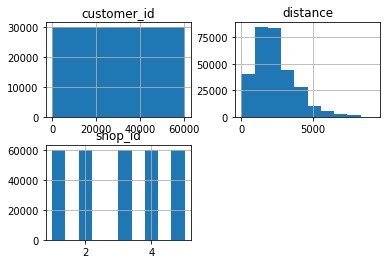

In [13]:
df_distances.hist()

Text(0.5, 1.0, "Distribution of distances between customers' homes and shops")

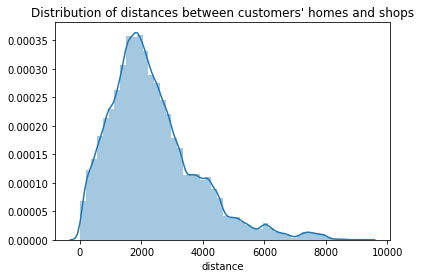

In [14]:
sns.distplot(df_distances["distance"])
plt.title("Distribution of distances between customers' homes and shops")

We can observe from the above graph that the shape of distance distribution is right skewed. It makes sense as no custmer would want to go to a shop which is far for them. Hence it is positively skewed. 

e) [5 points] For `supermarket_prices`, please describe the shape of the `price` distribution; is it normal? is it bi-modal? is it skewed? Briefly speculate why or why not your description is justified.



In [15]:
df_prices.shape

(4567, 2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021980768B48>,
      dtype=object)

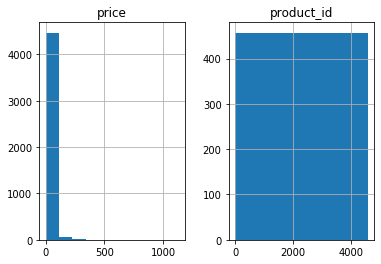

In [16]:
df_prices.hist()

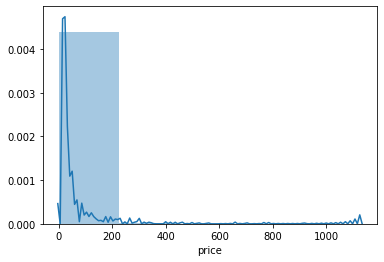

In [17]:
sns.distplot(df_prices["price"], bins=5)

We can observe from the above graph that the shape of price distribution is highly right skewed. It makes sense as no custmer would want to buy costlier products. Still we can see some data points even after 1000 Euros, but it is very negligible. Hence it is positively skewed.

f) [17 points] In (e) you investigated the shape of the `supermarket_prices` distribution. For efficiency purposes, first take a random sample of 10,000 customers. 

Then create a subset, $C_{lower}$, of customers for those customers that spent less than average on products. Create a subset, $C_{higher}$, of customers that spent more than average on products. Does the average `distance` traveled differ across these subsets? Is this difference _significant_ (show your work using a 95% confidence interval)? In your answer include why or why not your explanation is justified.



In [18]:
prices_purchases_merged = df_prices.merge(df_purchases, 
                      how="left", 
                      on="product_id")

In [19]:
total_merged = prices_purchases_merged.merge(df_distances, 
                                           how="left", 
                                           on=["customer_id", "shop_id"])

In [20]:
df_sample = total_merged.sample(n=10000,random_state=671)

In [21]:
df_sample["QuantityPrice"] = df_sample["quantity"]*df_sample["price"]
df_sample.head(5)

,product_id,price,customer_id,shop_id,quantity,distance,QuantityPrice
3350267,1012,2.541,14615.0,1.0,2.0,2715.757416,5.082
10670759,3507,1.148,43990.0,2.0,3.0,2721.216207,3.444
3542042,1122,0.960,54835.0,1.0,1.0,3025.296484,0.960
10305573,3330,0.917,23722.0,1.0,4.0,1773.603713,3.668
4624325,1437,1.034,15851.0,1.0,1.0,2769.113381,1.034


In [22]:
df_groupby_sample = (df_sample.groupby(["customer_id"])
                     ['QuantityPrice', 'quantity'].sum()
                     .sort_values(by="QuantityPrice",ascending = False))

df_groupby_sample.head(5)

C:\Users\yashu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,QuantityPrice,quantity
customer_id,,
18658.0,805.000,125.0
50370.0,787.569,1.0
37168.0,557.757,1.0
46947.0,525.125,25.0
30361.0,491.202,120.0


In [23]:
total_mean = df_groupby_sample["QuantityPrice"].sum()/df_groupby_sample["quantity"].sum()
total_mean

2.3217203250890015

In [24]:
df_sample_updated = df_sample.merge(df_groupby_sample['QuantityPrice'], 
                                    how="left", 
                                    on="customer_id")
df_sample_updated

,product_id,price,customer_id,shop_id,quantity,distance,QuantityPrice_x,QuantityPrice_y
0,1012,2.541,14615.0,1.0,2.0,2715.757416,5.082,5.082
1,3507,1.148,43990.0,2.0,3.0,2721.216207,3.444,3.444
2,1122,0.960,54835.0,1.0,1.0,3025.296484,0.960,0.960
3,3330,0.917,23722.0,1.0,4.0,1773.603713,3.668,3.668
4,1437,1.034,15851.0,1.0,1.0,2769.113381,1.034,1.034
...,...,...,...,...,...,...,...,...
9995,3227,1.083,41481.0,2.0,5.0,4615.395063,5.415,5.415
9996,2659,2.239,23487.0,1.0,1.0,1773.508423,2.239,2.239
9997,481,1.159,30003.0,1.0,1.0,2032.842737,1.159,1.159
9998,4155,5.420,40719.0,1.0,1.0,2821.257415,5.420,20.261


In [25]:
c_lower = df_sample_updated[df_sample_updated['QuantityPrice_y'] < total_mean]
c_lower.head(5).sort_values(by=['QuantityPrice_y'], ascending=False)

,product_id,price,customer_id,shop_id,quantity,distance,QuantityPrice_x,QuantityPrice_y
8,2649,2.137,33846.0,1.0,1.0,3860.018559,2.137,2.137
11,450,1.817,59439.0,2.0,1.0,216.075670,1.817,1.817
9,397,1.804,20304.0,2.0,1.0,2049.097936,1.804,1.804
4,1437,1.034,15851.0,1.0,1.0,2769.113381,1.034,1.034
2,1122,0.960,54835.0,1.0,1.0,3025.296484,0.960,0.960


In [26]:
c_higher = df_sample_updated[df_sample_updated['QuantityPrice_y'] > total_mean]
c_higher.head(5).sort_values(by=['QuantityPrice_y'], ascending=False)

,product_id,price,customer_id,shop_id,quantity,distance,QuantityPrice_x,QuantityPrice_y
6,1140,4.005,17700.0,2.0,2.0,2168.122780,8.010,8.010
0,1012,2.541,14615.0,1.0,2.0,2715.757416,5.082,5.082
5,3116,1.323,4656.0,1.0,1.0,2352.100414,1.323,3.929
3,3330,0.917,23722.0,1.0,4.0,1773.603713,3.668,3.668
1,3507,1.148,43990.0,2.0,3.0,2721.216207,3.444,3.444


In [27]:
c_lower_avg_distance = c_lower['distance'].mean()
c_lower_avg_distance

2010.3520901293

In [28]:
c_higher_avg_distance = c_higher['distance'].mean()
c_higher_avg_distance

2027.8770124168232

In [29]:
c_higher_avg_distance - c_lower_avg_distance

17.524922287523168

In [30]:
stats.ttest_ind(c_lower['distance'], c_higher['distance'], equal_var = False)

Ttest_indResult(statistic=-0.5930736502469206, pvalue=0.5531591111121257)

From the above calculation we can observe that the p-value is greater. Hence the difference in average distance is not statistically significant at the 95% confidence interval. Hence we can say that the average distance customers that spent less than average on products travel and the average distance that customers spent more than average on products travel are not the same.


**The main deliverable** for this part of the homework is 1) a step-by-step exploration and answers within a Jupyter Notebook, 2) a PDF document containing the answers to each of the questions above (this can be a PDF version of your Jupyter notebook).

# 2.2 Part 2: Applying Itemset Mining [50 Points]

For this part of the homework you will use itemset mining techniques to explore various relationships to the distance traveled by customers. Using the "language" of these data mining techniques to describe and justify patterns observed in a dataset is one of the primary contributions a data scientist can make in industry.

a) [6 Points] For all products sold what are the top 20 most frequent products?



In [31]:
top_20_products = (total_merged.groupby(["product_id"])
                .quantity.sum()
                .reset_index()
                .sort_values(by="quantity",ascending = False))

top_20_products.head(20)

,product_id,quantity
111,112,862168.0
2097,2098,761520.0
2357,2358,578662.0
1668,1669,560800.0
1644,1645,479372.0
1929,1930,457221.0
2095,2096,400223.0
1233,1234,372193.0
2830,2831,368098.0
1803,1804,342247.0


b) [12 Points] Each top 20 product was brought by a set of customers. What is the average distance traveled to the top 20 products by customers (that is, people traveled to get the top 20 products, how much did they travel on average)? What is the average distance traveled to all other products not in the top 20? Is there a difference? Is it a signicant difference?



In [32]:
total_dist_top_products = (total_merged.groupby(["product_id"])
                                .distance.sum()
                                .reset_index()
                                .sort_values(by="distance",ascending = False))

total_dist_top_products.head(20)

,product_id,distance
111,112,8.945105e+07
2097,2098,8.534671e+07
1668,1669,8.085988e+07
2357,2358,7.602659e+07
2095,2096,7.477816e+07
1929,1930,7.098397e+07
1233,1234,6.748525e+07
1644,1645,6.707912e+07
3040,3041,6.685078e+07
1653,1654,6.531216e+07


In [33]:
# Sum of distance column of total_dist_top_products.head(20) gives the total distance travelled by 20 customers. To get avergae divide by 20.
avg_dist_top_products = (total_dist_top_products.head(20).distance.sum())/20
avg_dist_top_products

68408237.88567622

The average distance traveled to the top 20 products by customers (that is, people traveled to get the top 20 products is 68,408,237.88 mtr.

In [34]:
total_dist_rest_products = total_dist_top_products.iloc[21:]
total_dist_rest_products

,product_id,distance
1664,1665,5.915762e+07
115,116,5.857860e+07
1804,1805,5.806352e+07
2784,2785,5.770591e+07
2113,2114,5.692847e+07
...,...,...
4337,4338,0.000000e+00
4112,4113,0.000000e+00
4536,4537,0.000000e+00
2694,2695,0.000000e+00


In [35]:
avg_dist_rest_products = (total_dist_rest_products.distance.sum())/4546
avg_dist_rest_products

5157041.832213152

The average distance traveled to all other products not in the top 20 is 5,157,041.83 mtr. 

Yes, there is difference.

In [36]:
avg_dist_top_products - avg_dist_rest_products

63251196.05346307

The difference between the average distance customers travel for top 20 products and the average distance customers travel for all other products not in the top 20 is 63,251,196 mtr.

In [37]:
stats.ttest_ind(total_dist_top_products.head(20).distance, total_dist_rest_products.distance, equal_var = False)

Ttest_indResult(statistic=32.97424587522935, pvalue=2.3051271520155692e-18)

From the above calculation of t-test we can observe that the p-value (2.3051271520155692e-18) is much lower than 0.05. Hence the difference in average distance is statistically significant at the 95% confidence interval. Hence the average distance customers travel for top 20 products and the average distance customers travel for all other products not in the top 20 are not the same.

c) [6 Points] In itemset mining why would we ignore very high selling products that are readily available, like `toothbrush`? Are high selling, easily available products likely to yield high confidence and high interest association rules?

d) [6 points] Referring to Part 1, for $C_{lower}$ customers what are the top 20 most frequent products? For $C_{higher}$ customers what are the top 20 most frequent products?

In [38]:
c_lower_top_products = pd.DataFrame(c_lower.groupby('product_id')['quantity'].sum()
                              .sort_values(ascending=False).head(20))
c_lower_top_products

,quantity
product_id,
2797,43.0
1645,35.0
113,34.0
2098,25.0
112,23.0
115,21.0
2096,21.0
3687,21.0
326,20.0


In [39]:
c_higher_top_products = pd.DataFrame(c_higher.groupby('product_id')['quantity']
                               .sum().sort_values(ascending=False).head(20))

c_higher_top_products

,quantity
product_id,
112,1621.0
2096,734.0
1669,607.0
2358,518.0
3507,400.0
1807,363.0
710,302.0
2831,301.0
1599,296.0


e) [20 points total] Imagine that _Coop_ wants to negotiate a better deal from its suppliers. To argue for a better deal, Coop wants to ask for bulk discounts on _groups_ of products. Coop only cares about the top 5 products sold by quantity found in 2(d) above.

To help justify what groups of products should be considered Coop has asked you:

 * [worth 7 points] For $C_{lower}$ customers, using the Apriori algorithm, what are the most frequent itemsets that are purchased from stores? For computational efficiency only run the algorithm on data containing the products in $C_{lower}$'s top 5 most frequently sold products.
 * [worth 7 points] For $C_{higher}$ customers, using and Apriori algorithm, what are the most frequent itemsets that are purchased from stores? For computational efficiency only run the algorithm on data containing the products in $C_{higher}$'s top 5 most frequently sold products.
 * [worth 6 points] Computer similarity between the $C_{lower}$ and $C_{higher}$ itemsets using Jaccard similarity. Compare only itemsets in the top 20 ranked by confidence. Are there any itemsets have a Jaccard similarity above 0?
 
The apriori algorithm parameters should be set to: `min_confidence=0.50`, `min_lift=1.0` and `max_length=5`


#### Apriori, $C_{lower}$

In [40]:
c_lower_top_5 = c_lower_top_products.head(5).reset_index()
c_lower_top_5_list = c_lower_top_5["product_id"].to_list()
c_lower_top_5_list

[2797, 1645, 113, 2098, 112]

In [41]:
purchases_lower = c_lower[c_lower["product_id"].isin(c_lower_top_5_list)]
purchases_lower.sample(5)

,product_id,price,customer_id,shop_id,quantity,distance,QuantityPrice_x,QuantityPrice_y
5667,1645,0.713,25558.0,2.0,1.0,2658.154950,0.713,0.713
568,2797,0.358,18514.0,2.0,6.0,3393.324322,2.148,2.148
9122,1645,0.713,29432.0,2.0,3.0,1264.000980,2.139,2.139
3657,1645,0.713,45976.0,1.0,1.0,2930.727212,0.713,0.713
917,113,0.269,49096.0,1.0,4.0,2523.716333,1.076,1.076


In [42]:
shop_id_lower = purchases_lower.groupby(['shop_id'])['product_id'].unique()
pd.DataFrame(shop_id_lower)

,product_id
shop_id,
1.0,"[1645, 2098, 113, 112, 2797]"
2.0,"[112, 2797, 2098, 1645, 113]"
3.0,"[1645, 2098, 2797]"
4.0,"[2098, 113, 2797]"
5.0,"[2797, 113]"


In [43]:
apriori_lower_list = shop_id_lower.to_list()
frequent_items_lower = apriori(apriori_lower_list, min_confidence=0.50, min_lift=1.0, max_length=5)
frequent_items_lower

<generator object apriori at 0x0000021980CB4A48>

In [44]:
apriori_lower = list(frequent_items_lower)
apriori_lower

[RelationRecord(items=frozenset({113}), support=0.8, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({113}), confidence=0.8, lift=1.0)]),
 RelationRecord(items=frozenset({1645}), support=0.6, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({1645}), confidence=0.6, lift=1.0)]),
 RelationRecord(items=frozenset({2098}), support=0.8, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({2098}), confidence=0.8, lift=1.0)]),
 RelationRecord(items=frozenset({2797}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({2797}), confidence=1.0, lift=1.0)]),
 RelationRecord(items=frozenset({112, 113}), support=0.4, ordered_statistics=[OrderedStatistic(items_base=frozenset({112}), items_add=frozenset({113}), confidence=1.0, lift=1.25), OrderedStatistic(items_base=frozenset({113}), items_add=frozenset({112}), confidence=0.5, lift=1.25)]),
 RelationRecord(items=froz

In [45]:
len(apriori_lower)

29

In [46]:
def extract_apriori_solution(results):
    df = pd.DataFrame(columns=('Items','Support','Confidence','Lift'))

    Support =[]
    Confidence = []
    Lift = []
    Items = []

    for RelationRecord in results:
        Items.append(RelationRecord.items)
        Support.append(RelationRecord.support)
        Confidence.append(RelationRecord.ordered_statistics[0][2])
        Lift.append(RelationRecord.ordered_statistics[0][3])

    df['Items'] = Items                                  
    df['Support'] = Support
    df['Confidence'] = Confidence
    df['Lift']= Lift
    
    return df

extract_apriori_solution(apriori_lower)

,Items,Support,Confidence,Lift
0,(113),0.8,0.800000,1.000000
1,(1645),0.6,0.600000,1.000000
2,(2098),0.8,0.800000,1.000000
3,(2797),1.0,1.000000,1.000000
4,"(112, 113)",0.4,1.000000,1.250000
5,"(112, 1645)",0.4,1.000000,1.666667
6,"(112, 2098)",0.4,1.000000,1.250000
7,"(112, 2797)",0.4,1.000000,1.000000
8,"(113, 2098)",0.6,0.600000,1.000000
9,"(113, 2797)",0.8,0.800000,1.000000


#### Apriori, $C_{higher}$

In [47]:
c_higher_top_5 = c_higher_top_products.head(5).reset_index()
c_higher_top_5_list = c_higher_top_5["product_id"].to_list()
c_higher_top_5_list

[112, 2096, 1669, 2358, 3507]

In [48]:
purchases_higher = c_higher[c_higher["product_id"].isin(c_higher_top_5_list)]
purchases_higher.sample(5)

,product_id,price,customer_id,shop_id,quantity,distance,QuantityPrice_x,QuantityPrice_y
4212,2096,0.649,52274.0,1.0,8.0,1834.251463,5.192,5.192
7723,3507,1.148,14604.0,2.0,3.0,2816.331925,3.444,3.444
666,112,0.334,20248.0,1.0,38.0,3409.006666,12.692,12.692
9039,3507,1.148,16295.0,3.0,218.0,1070.265246,250.264,250.264
4844,1669,1.200,22637.0,1.0,7.0,1011.911637,8.400,14.965


In [49]:
shop_id_higher = purchases_higher.groupby(['shop_id'])['product_id'].unique()
pd.DataFrame(shop_id_higher)

,product_id
shop_id,
1.0,"[112, 1669, 2096, 2358, 3507]"
2.0,"[3507, 1669, 2358, 112, 2096]"
3.0,"[112, 2358, 2096, 1669, 3507]"
4.0,"[1669, 112, 3507, 2358, 2096]"
5.0,"[1669, 2358]"


In [50]:
apriori_higher_list = shop_id_higher.to_list()
frequent_items_higher = apriori(apriori_higher_list, min_confidence=0.50, min_lift=1.0, max_length=5)
frequent_items_higher

<generator object apriori at 0x0000021980EAA7C8>

In [51]:
apriori_higher = list(frequent_items_higher)
apriori_higher

[RelationRecord(items=frozenset({112}), support=0.8, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({112}), confidence=0.8, lift=1.0)]),
 RelationRecord(items=frozenset({1669}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({1669}), confidence=1.0, lift=1.0)]),
 RelationRecord(items=frozenset({2096}), support=0.8, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({2096}), confidence=0.8, lift=1.0)]),
 RelationRecord(items=frozenset({2358}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({2358}), confidence=1.0, lift=1.0)]),
 RelationRecord(items=frozenset({3507}), support=0.8, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({3507}), confidence=0.8, lift=1.0)]),
 RelationRecord(items=frozenset({112, 1669}), support=0.8, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozens

In [52]:
len(apriori_higher)

31

In [53]:
extract_apriori_solution(apriori_higher)

,Items,Support,Confidence,Lift
0,(112),0.8,0.8,1.0
1,(1669),1.0,1.0,1.0
2,(2096),0.8,0.8,1.0
3,(2358),1.0,1.0,1.0
4,(3507),0.8,0.8,1.0
5,"(112, 1669)",0.8,0.8,1.0
6,"(112, 2096)",0.8,0.8,1.0
7,"(112, 2358)",0.8,0.8,1.0
8,"(112, 3507)",0.8,0.8,1.0
9,"(2096, 1669)",0.8,0.8,1.0


#### Jaccard Similarity

In [54]:
frequent_itemset_lower = []
sorted_apriori_lower = sorted(apriori_lower, reverse=True)
for item in sorted_apriori_lower:
    frequent_itemset_lower.append((item.items, item.ordered_statistics[0].confidence))

top_set_lower = pd.DataFrame(frequent_itemset_lower[:20])
top_set_lower

,0,1
0,"(1645, 2797, 112, 113, 2098)",1.0
1,"(112, 1645)",1.0
2,"(112, 2797)",1.0
3,"(2098, 1645)",0.6
4,"(2098, 2797)",0.8
5,"(112, 113, 1645)",1.0
6,"(112, 113, 2098)",1.0
7,"(113, 2098)",0.6
8,"(112, 113, 2797)",1.0
9,"(112, 113)",1.0


In [55]:
frequent_itemset_higher = []
sorted_apriori_higher = sorted(apriori_higher, reverse=True)
for item in sorted_apriori_higher:
    frequent_itemset_higher.append((item.items, item.ordered_statistics[0].confidence))

top_set_higher = pd.DataFrame(frequent_itemset_higher[:20])
top_set_higher

,0,1
0,"(1669, 112, 2096, 3507, 2358)",0.8
1,"(112, 2096)",0.8
2,(2096),0.8
3,"(112, 3507)",0.8
4,"(2096, 2358)",0.8
5,"(3507, 2358)",0.8
6,"(112, 2096, 1669)",0.8
7,"(112, 1669, 2358)",0.8
8,"(1669, 2358)",1.0
9,"(112, 3507, 1669)",0.8


In [56]:
def jaccard_similarity(a, b):
    return len( a.intersection(b) ) / len( a.union(b) )

In [57]:
lower_list = top_set_lower.iloc[:, 0].to_list()
higher_list = top_set_higher.iloc[:, 0].to_list()
itemset_list = []
for itemset_1 in lower_list:
    for itemset_2 in higher_list:
        itemset_list.append(jaccard_similarity(itemset_1, itemset_2))
        
itemset_list

[0.1111111111111111,
 0.16666666666666666,
 0.0,
 0.16666666666666666,
 0.0,
 0.0,
 0.14285714285714285,
 0.14285714285714285,
 0.0,
 0.14285714285714285,
 0.16666666666666666,
 0.0,
 0.14285714285714285,
 0.16666666666666666,
 0.14285714285714285,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.16666666666666666,
 0.3333333333333333,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.25,
 0.25,
 0.0,
 0.25,
 0.3333333333333333,
 0.0,
 0.25,
 0.3333333333333333,
 0.25,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0,
 0.16666666666666666,
 0.3333333333333333,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.25,
 0.25,
 0.0,
 0.25,
 0.3333333333333333,
 0.0,
 0.25,
 0.3333333333333333,
 0.25,
 0.25,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14285714285714285,
 0.25,
 0.0,
 0.25,
 0.0,
 0.0,
 0.2,
 

In [58]:
len(itemset_list)

400

In [59]:
Counter(itemset_list)

Counter({0.1111111111111111: 1,
         0.16666666666666666: 13,
         0.0: 279,
         0.14285714285714285: 12,
         0.3333333333333333: 12,
         0.25: 42,
         0.2: 40,
         0.125: 1})

From the above code it can be observed that some of the itemsets have Jaccard similarity above 0. 

Some of the code snippets were taken from Kwame's piazza post/office hours(https://piazza.com/class/kfhm1opmyq3xf?cid=22) and stackoverflow(https://stackoverflow.com/questions/52688220/python-apyori-sorting-by-lift). The logic for 2.2(b) was from the office hours with Prof.Dillon. 

# 3 Submission

All submissions should be made electronically by 11:59 PM EST on October 5, 2020.

Here are the main deliverables:

* A PDF version of your executed Jupyter notebook
* The actual Jupyter notebook, so that we can check your results

# 4 Academic Honesty

Unless otherwise specified in the homework, all submitted work must be your own original work. Any excerpts, statements, or phrases from the work of others must be clearly identified as a quotation, and a proper citation provided. Any violation of the University's policies on Academic and Professional Integrity may result in serious penalties, which might range
from failing a homework, to failing a course, to being expelled from the program. Violations of academic and professional integrity will be reported to the concerned authorities. Consequences of academic misconduct are determined by the faculty instructor; additional sanctions may be imposed.

# 5 References

> Pennacchioli et al. "Explaining the product range effect in purchase data" (2013) BigData. DOI: [doi.org/10.1109/BigData.2013.6691634](https://doi.org/10.1109/BigData.2013.6691634)